In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

#Function

In [ ]:
def plot_loss(history):
  history_dataframe = pd.DataFrame(history.history)

  min_loss_index = history_dataframe[history_dataframe['loss']==min(history_dataframe['loss'])].index.values
  min_loss = history_dataframe.loc[min_loss_index]['loss']
  min_val_loss_index = history_dataframe[history_dataframe['val_loss']==min(history_dataframe['val_loss'])].index.values
  min_val_loss = history_dataframe.loc[min_val_loss_index]['val_loss']

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(min_loss_index, min_loss, 'o', c='k', ms=4, label='min loss')
  plt.plot(min_val_loss_index, min_val_loss, 'o', c='k', ms=4, label='min val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()

  print("Minimun Loss :", min_loss)
  print("---------------------------------------")
  print("Minimun Validation Loss :", min_val_loss)

In [ ]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

In [ ]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#Datetime Parser


In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Colab_Test/Dataset/6. Deep Learning/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

dataset.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

#Plot Dataset

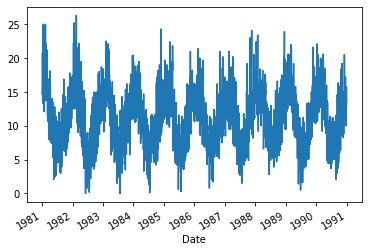

In [ ]:
dataset.plot()
plt.show()

### **Pada data diatas terdapat Seasonality yang dapat dilihat dari data yang stabil namun tidak ada kenaikan pada grafik.**

#Processing Time-Series Data

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [ ]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [ ]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

#Deep Learning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf, random
from tensorflow.keras.layers import LSTM

##Baseline Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32
reset_random_seeds()

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

base_model = Sequential()
base_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
base_model.add(Dense(1))
base_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
reset_random_seeds()
history_basemodel = base_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0590
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0552
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0548
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0547
Epoch 5/1000
86/86 [==============================] - 0s 973us/step - loss: 0.0596 - val_loss: 0.0547
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0546
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0546
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0546
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0546
Epoch 10/1000
86/86 [==============================] - 0s 993us/step - loss: 0.0595 - val_loss: 0.

In [ ]:
loss = base_model.evaluate(feature_test, label_test, verbose=2)
print("Test Loss -> ",loss)

29/29 - 0s - loss: 0.0540
Test Loss ->  0.05397732928395271


In [ ]:
history_dataframe = pd.DataFrame(history_basemodel.history)
history_dataframe['epoch'] = history_basemodel.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
261,0.058783,0.053976,261
568,0.058757,0.053976,568
498,0.058762,0.053977,498
971,0.058728,0.053977,971
404,0.058755,0.053977,404
...,...,...,...
4,0.059644,0.054673,4
3,0.059678,0.054689,3
2,0.059823,0.054793,2
1,0.061318,0.055188,1


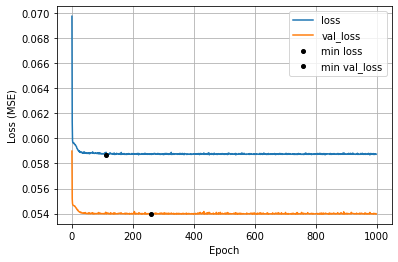

Minimun Loss : 111    0.058679
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 261    0.053976
Name: val_loss, dtype: float64


In [ ]:
plot_loss(history_basemodel)

##Deeper Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32
reset_random_seeds()

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(4, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
reset_random_seeds()
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0574
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0560
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0559
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0557
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0556
Epoch 6/1000
86/86 [==============================] - 0s 989us/step - loss: 0.0603 - val_loss: 0.0555
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0553
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0551
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0550
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.05

In [ ]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
253,0.058254,0.053869,253
202,0.058325,0.053869,202
229,0.058242,0.053875,229
197,0.058365,0.053876,197
139,0.058402,0.053877,139
...,...,...,...
4,0.060370,0.055584,4
3,0.060483,0.055701,3
2,0.060630,0.055856,2
1,0.061067,0.056032,1


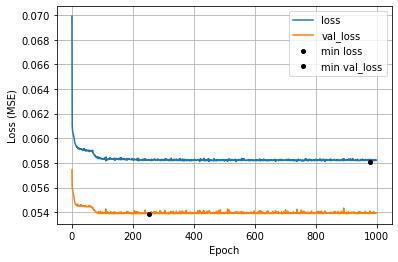

Minimun Loss : 978    0.058106
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 253    0.053869
Name: val_loss, dtype: float64


In [ ]:
plot_loss(deeper_model_history)

##Wilder Model

In [ ]:
neurons = 50
epoch = 1000
batch_size = 32
reset_random_seeds()

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
reset_random_seeds()
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0542
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0545
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0539
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0538
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0540
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0540
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0538
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0537

In [ ]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
589,0.057465,0.053695,589
53,0.057976,0.053710,53
31,0.057992,0.053712,31
23,0.058014,0.053724,23
15,0.058084,0.053731,15
...,...,...,...
1,0.058797,0.054491,1
931,0.057388,0.054493,931
880,0.057402,0.054567,880
658,0.057467,0.054580,658


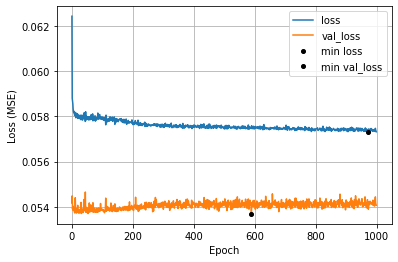

Minimun Loss : 971    0.057298
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 589    0.053695
Name: val_loss, dtype: float64


In [ ]:
plot_loss(wider_model_history)

##LSTM

In [ ]:
epoch = 1000
batch_size = 32
# reset_random_seeds()

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(40, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# reset_random_seeds()
lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0664 - val_loss: 0.0552
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0543
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0541
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0539

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
341,0.057919,0.053774,341
304,0.057996,0.053777,304
334,0.057960,0.053779,334
374,0.057895,0.053782,374
355,0.058020,0.053783,355
...,...,...,...
892,0.057675,0.054268,892
511,0.057644,0.054292,511
44,0.058094,0.054307,44
111,0.057974,0.054350,111


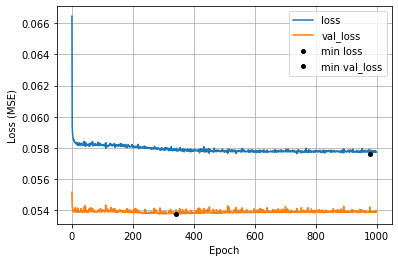

Minimun Loss : 978    0.057636
Name: loss, dtype: float64
---------------------------------------
Minimun Validation Loss : 341    0.053774
Name: val_loss, dtype: float64


In [ ]:
plot_loss(lstm_model_history)

#Kesimpulan :

###**Dari dataset Daily-Min-Temperatures, saya melakukan pengujian dengan 4 model yaitu baseline model, deeper model, wider model dan LSTM. Dari data Daily-Min-Temperatures, Wider Model lah yang terbaik untuk menghasilkan MSE terkecil yaitu dengan nilai 0.0536 di bandingkan dengan menggunakan model lain.**

### **Namun pada dataset lain hasil yang didapatkan jg berbeda.**